In [75]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

import re
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

/kaggle/input/processed-dataset/processed_data.csv
/kaggle/input/stacksample/Answers.csv
/kaggle/input/stacksample/Questions.csv
/kaggle/input/stacksample/Tags.csv


In [76]:
df = pd.read_csv("Questions.csv", encoding="ISO-8859-1")

In [113]:
tags = pd.read_csv("Tags.csv", encoding="ISO-8859-1")

In [78]:
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [79]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


**Merging Questions.csv and Tags.csv**

First group tags by id and then merge.

In [115]:
tags['Tag'] = tags['Tag'].astype(str)

In [81]:
tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

Convert the Series back into a DataFrame and add a new default integer index.

In [82]:
tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [83]:
tags = pd.DataFrame({'Id':tags.index, 'Tags':tags.values})

In [84]:
tags.head()

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


Now we drop unrelated columns from Question.csv

In [85]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [86]:
df.head()

,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


Drop the questions with score less than 6

In [87]:
df = df.query('Score >= 6')

In [88]:
df = df.merge(tags, on='Id')

Drop the ID and Score columns now

In [89]:
df.drop(columns=['Id', 'Score'], inplace=True)

In [90]:
df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [91]:
print((df.isnull().sum() / len(df)) * 100)
# No missing values

Title    0.0
Body     0.0
Tags     0.0
dtype: float64


In [92]:
df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


**Choosing most common tags**

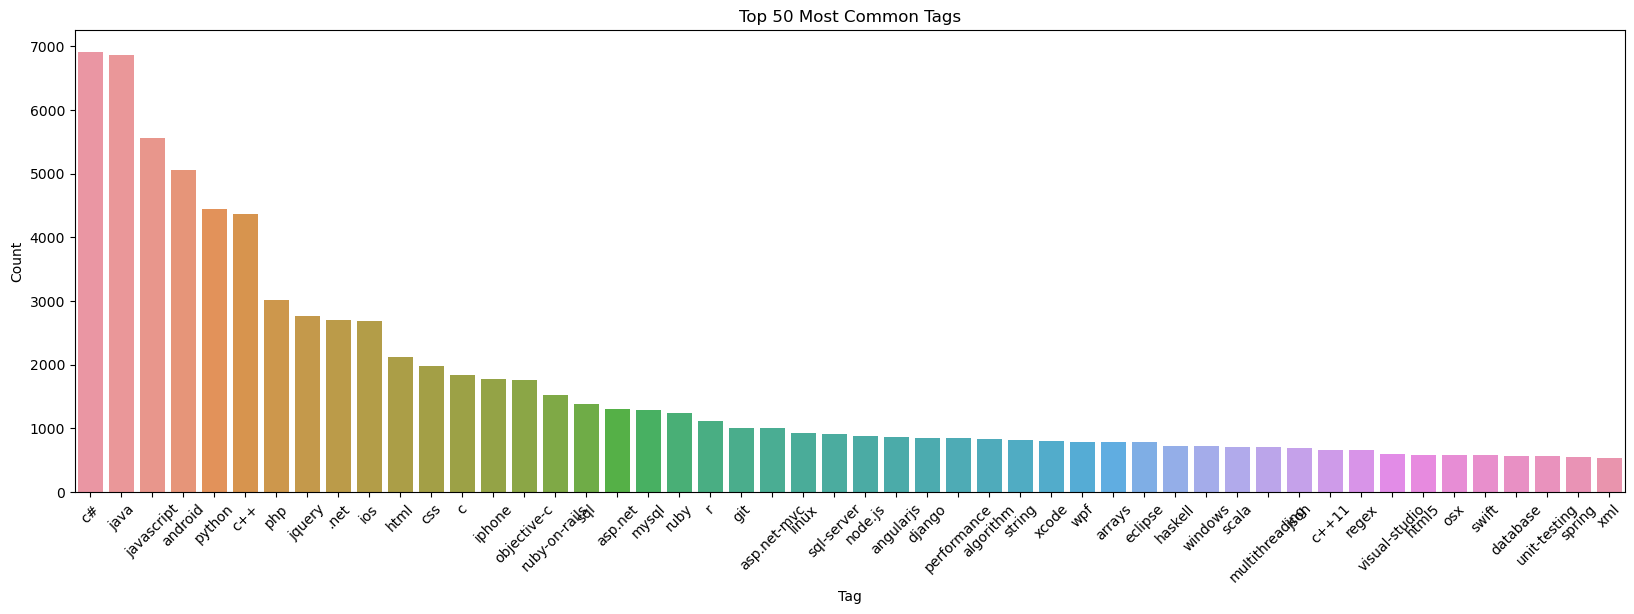

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns


tag_counts = df['Tags'].str.split().explode().value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=tag_counts.index[:50], y=tag_counts.values[:50])
plt.title('Top 50 Most Common Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [105]:
df['Tags'] = df['Tags'].apply(lambda x: x.split())

In [106]:
f_list = [item for sublist in df['Tags'].values for item in sublist]
imp = nltk.FreqDist(f_list)
count = imp.most_common(200)
top_tags = [word[0] for word in count]

In [107]:
top_tags

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

In [108]:
def common(tags):
    tags_f = []
    for i in range(0, len(tags)):
        if tags[i] in top_tags:
            tags_f.append(tags[i])
    return tags_f

In [109]:
df['Tags'] = df['Tags'].apply(lambda x: common(x))
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [110]:
df.dropna(subset=['Tags'], inplace=True)

**Cleansing Body content**

In [123]:
# Remove HTML Formatting
df['Body'] = df['Body'].apply(lambda x: BeautifulSoup(x).get_text())

In [124]:
# Clean the text
def processed_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [125]:
df['Body'] = df['Body'].apply(lambda x: processed_text(x)) 

In [126]:
token=ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [127]:
def rem_whitespaces(mylist):
    newlist = [item.strip() if isinstance(item, str) else item for item in mylist]
    return [item for item in newlist if item != '']


In [128]:
def clean_punct1(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in top_tags:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = rem_whitespaces(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [129]:
df['Body'] = df['Body'].apply(lambda x: clean_punct1(x)) 

In [130]:
def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    words=token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [131]:
df['Body'] = df['Body'].apply(lambda x: remove_stop_words(x)) 

In [132]:
df['Title'] = df['Title'].apply(lambda x: str(x))
df['Title'] = df['Title'].apply(lambda x: processed_text(x)) 
df['Title'] = df['Title'].apply(lambda x: clean_punct1(x))
df['Title'] = df['Title'].apply(lambda x: remove_stop_words(x)) 

In [133]:
df

,Title,Body,Tags
1,good branching merging tutorials tortoisesvn,really good tutorials explaining branching mer...,[svn]
2,asp.net site maps,anyone got experience creating sql-based asp.n...,"[sql, asp.net]"
3,function creating color wheels,something pseudo-solved many times never quite...,"[algorithm, language-agnostic]"
4,adding scripting functionality .net applications,little game written c uses database back-end t...,"[c#, .net, compiler-construction]"
5,use nested classes case,working collection classes used video playback...,"[c++, oop, class]"
...,...,...,...
72945,use dict subset dataframe,say given dataframe columns categorical data d...,"[python, pandas]"
72946,way use itertools python clean nested iterations,let say following code 123 b 246 c 357 j b k c...,[python]
72947,force file ordering f# projects using vscode,trying work vscode websharper project ionide p...,[f#]
72948,result data returned void gets broken,working project huge legacy code base trying r...,[c++]


**Merge Title and Body**

In [134]:
df['Questions'] = df['Title'] + ' ' + df['Body']

In [135]:
df.drop(columns=['Title', 'Body'], inplace=True)

In [136]:
new_order = ['Questions', 'Tags']  # Define the desired column order

df = df[new_order]

In [137]:
df

,Questions,Tags
1,good branching merging tutorials tortoisesvn r...,[svn]
2,asp.net site maps anyone got experience creati...,"[sql, asp.net]"
3,function creating color wheels something pseud...,"[algorithm, language-agnostic]"
4,adding scripting functionality .net applicatio...,"[c#, .net, compiler-construction]"
5,use nested classes case working collection cla...,"[c++, oop, class]"
...,...,...
72945,use dict subset dataframe say given dataframe ...,"[python, pandas]"
72946,way use itertools python clean nested iteratio...,[python]
72947,force file ordering f# projects using vscode t...,[f#]
72948,result data returned void gets broken working ...,[c++]


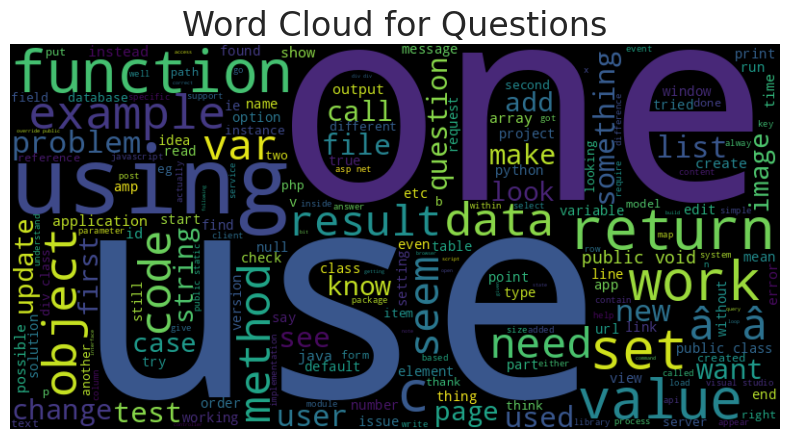

In [212]:
from wordcloud import WordCloud

question_text = ' '.join(df['Questions'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(question_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

In [140]:
selected_columns = ['Questions', 'Tags'] 
df[selected_columns].to_csv('processed_data.csv', index=False)

In [ ]:
-----------------------------

In [ ]:
-----------------------------

In [ ]:
-----------------------------

# Training Model

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('processed_data.csv')

In [4]:
df.head()

,Questions,Tags
0,good branching merging tutorials tortoisesvn r...,['svn']
1,asp.net site maps anyone got experience creati...,"['sql', 'asp.net']"
2,function creating color wheels something pseud...,"['algorithm', 'language-agnostic']"
3,adding scripting functionality .net applicatio...,"['c#', '.net', 'compiler-construction']"
4,use nested classes case working collection cla...,"['c++', 'oop', 'class']"


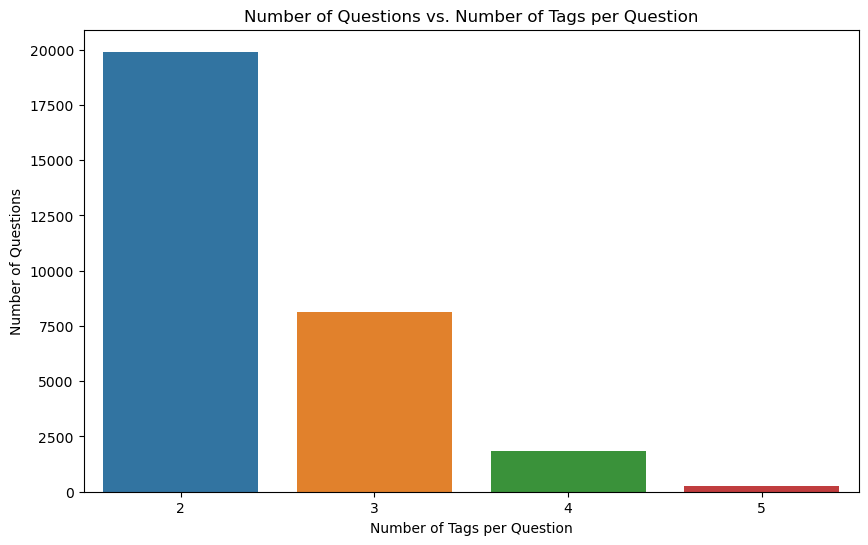

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Tag_Count'] = df['Tags'].str.split().apply(len)
questions_with_multiple_tags = df[df['Tag_Count'] > 1]

plt.figure(figsize=(10, 6))
sns.countplot(data=questions_with_multiple_tags, x='Tag_Count')
plt.xlabel('Number of Tags per Question')
plt.ylabel('Number of Questions')
plt.title('Number of Questions vs. Number of Tags per Question')

plt.show()


In [28]:
type(df['Tags'][0])

str

In [29]:
df['Tags'][0]

"['svn']"

In [5]:
import ast
ast.literal_eval(df['Tags'][0])

['svn']

In [6]:
df['Tags'] = df['Tags'].apply(lambda x: ast.literal_eval(x))
df.head()

,Questions,Tags
0,good branching merging tutorials tortoisesvn r...,[svn]
1,asp.net site maps anyone got experience creati...,"[sql, asp.net]"
2,function creating color wheels something pseud...,"[algorithm, language-agnostic]"
3,adding scripting functionality .net applicatio...,"[c#, .net, compiler-construction]"
4,use nested classes case working collection cla...,"[c++, oop, class]"


In [7]:
y = df['Tags']
y

0                                    [svn]
1                           [sql, asp.net]
2           [algorithm, language-agnostic]
3        [c#, .net, compiler-construction]
4                        [c++, oop, class]
                       ...                
54076                                [c++]
54077                        [c++, lambda]
54078                     [python, pandas]
54079                             [python]
54080                                 [f#]
Name: Tags, Length: 54081, dtype: object

In [8]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df['Tags'])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
multilabel.classes_

array(['.net', 'ajax', 'algorithm', 'amazon-web-services', 'android',
       'android-layout', 'android-studio', 'angularjs', 'apache', 'api',
       'arrays', 'asp.net', 'asp.net-mvc', 'asp.net-mvc-3',
       'asp.net-mvc-4', 'asynchronous', 'authentication', 'backbone.js',
       'bash', 'boost', 'browser', 'c', 'c#', 'c++', 'c++11', 'caching',
       'casting', 'class', 'clojure', 'cocoa', 'cocoa-touch',
       'coding-style', 'collections', 'command-line',
       'compiler-construction', 'constructor', 'cordova', 'css', 'css3',
       'data-structures', 'database', 'date', 'datetime', 'debugging',
       'delphi', 'dependency-injection', 'design', 'design-patterns',
       'dictionary', 'django', 'dom', 'eclipse', 'emacs', 'email',
       'entity-framework', 'enums', 'events', 'excel', 'exception',
       'exception-handling', 'f#', 'facebook', 'file', 'firefox', 'forms',
       'function', 'functional-programming', 'gcc', 'generics', 'git',
       'github', 'go', 'google-app-engin

In [9]:
pd.DataFrame(y, columns = multilabel.classes_)

,.net,ajax,algorithm,amazon-web-services,android,android-layout,android-studio,angularjs,apache,api,...,visual-studio-2012,wcf,web-services,winapi,windows,winforms,wpf,xaml,xcode,xml
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
tfidf = TfidfVectorizer(analyzer = 'word',min_df=0.0, max_df = 1.0, strip_accents = None, encoding = 'utf-8', preprocessor=None, token_pattern=r"(?u)\S\S+",max_features=10000)
X = tfidf.fit_transform(df['Questions'])
X.shape, y.shape

((54081, 10000), (54081, 200))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [31]:
sgd = SGDClassifier()
lr = LogisticRegression(solver='lbfgs')
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
svc = LinearSVC()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [32]:
def jaccard_score(y_true, y_pred):
  jaccard = np.minimum(y_true, y_pred).sum(axis = 1)/np.maximum(y_true, y_pred).sum(axis = 1)
  return jaccard.mean()*100


def print_score(y_pred, clf):
  print("Clf: ", clf.__class__.__name__)
  print('Jacard score: {}'.format(jaccard_score(y_test, y_pred)))
  print('----')

In [33]:
sgdclf = OneVsRestClassifier(sgd)
sgdclf.fit(X_train, y_train)
y_pred = sgdclf.predict(X_test)
print_score(y_pred, sgd)

Clf:  SGDClassifier
Jacard score: 38.44805574998789
----


In [34]:
logistic = OneVsRestClassifier(lr)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
print_score(y_pred, lr)

Clf:  LogisticRegression
Jacard score: 36.54604524623938
----


In [16]:
percep = OneVsRestClassifier(perceptron)
percep.fit(X_train, y_train)
y_pred = percep.predict(X_test)
print_score(y_pred, perceptron)

Clf:  Perceptron
Jacard score: 45.94724133528792
----


In [17]:
pacclf = OneVsRestClassifier(pac)
pacclf.fit(X_train, y_train)
y_pred = pacclf.predict(X_test)
print_score(y_pred, pac)

Clf:  PassiveAggressiveClassifier
Jacard score: 48.00349537984741
----


In [24]:
classifier = LinearSVC(C=1.5, penalty = 'l1', dual=False, max_iter=10000)
svcclf2 = OneVsRestClassifier(classifier)
svcclf2.fit(X_train, y_train)
y_pred = svcclf2.predict(X_test)
print_score(y_pred, classifier)

Clf:  LinearSVC
Jacard score: 52.19266850680365
----


In [ ]:
"""param_grid = {
    'estimator__C':[1,10,100,1000]
}
from sklearn.model_selection import GridSearchCV

svc = OneVsRestClassifier(LinearSVC())
grid_search = GridSearchCV(
    estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(jaccard_score, greater_is_better=True)
)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)"""

In [35]:
mlpc.fit(X_train, y_train)
y_pred = mlpc.predict(X_test)
print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 47.69081883161573
----


In [182]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 34.17013343194355
----


In [38]:
import pickle
    
with open('tfidf.pkl', 'wb') as model_file:
    pickle.dump((tfidf), model_file)
with open('multilabel.pkl', 'wb') as model_file:
    pickle.dump((multilabel), model_file)
with open('svcclf2.pkl', 'wb') as model_file:
    pickle.dump((svcclf2), model_file)

**Confusion Matrix**

In [42]:
for i in range(y_train.shape[1]):
    print(multilabel.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

.net
[[10069   286]
 [  322   140]]

ajax
[[10739    12]
 [   44    22]]

algorithm
[[10654    47]
 [   59    57]]

amazon-web-services
[[10777     8]
 [   18    14]]

android
[[9912   74]
 [ 139  692]]

android-layout
[[10754    17]
 [   37     9]]

android-studio
[[10761     9]
 [   17    30]]

angularjs
[[10672    11]
 [   18   116]]

apache
[[10765    10]
 [   21    21]]

api
[[10771    14]
 [   28     4]]

arrays
[[10656    45]
 [   74    42]]

asp.net
[[10517    97]
 [  106    97]]

asp.net-mvc
[[10604    50]
 [   80    83]]

asp.net-mvc-3
[[10740    15]
 [   48    14]]

asp.net-mvc-4
[[10787     3]
 [   22     5]]

asynchronous
[[10784     6]
 [   22     5]]

authentication
[[10775     9]
 [   25     8]]

backbone.js
[[10793     1]
 [   10    13]]

bash
[[10712    18]
 [   35    52]]

boost
[[10781     5]
 [   13    18]]

browser
[[10773     7]
 [   27    10]]

c
[[10383   143]
 [  149   142]]

c#
[[9234  450]
 [ 449  684]]

c++
[[9914  203]
 [ 193  507]]

c++11
[[10655    63]
 

**Test**

In [211]:
title = "Rest API endpoint in flask should return json object"
question = "I have flask app which should return json after pinging api endpoint from postgres-sql server, how can I create a rest api"
test_input = [title + " " + question]
transformed = tfidf.transform(test_input)
xt = transformed

sgdoutput = multilabel.inverse_transform(sgdclf.predict(xt))
logisticop = multilabel.inverse_transform(logistic.predict(xt))
percepop = multilabel.inverse_transform(percep.predict(xt))
pacop = multilabel.inverse_transform(pacclf.predict(xt))
svcop = multilabel.inverse_transform(svcclf2.predict(xt))
mlpcop = multilabel.inverse_transform(mlpc.predict(xt))
rfcop = multilabel.inverse_transform(rfc.predict(xt))
print(f"sgdoutput: {sgdoutput}")
print(f"logisticop: {logisticop}")
print(f"percepop: {percepop}")
print(f"pacop: {pacop}")
print(f"svcop: {svcop}")
print(f"mlpcop: {mlpcop}")
print(f"rfcop: {rfcop}")


sgdoutput: [('json', 'python')]
logisticop: [('json', 'rest')]
percepop: [('json', 'python', 'rest')]
pacop: [('json', 'python', 'rest')]
svcop: [('json', 'postgresql', 'python', 'rest')]
mlpcop: [('json', 'rest')]
rfcop: [()]
